In [1]:
import time
import json
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Euroleaks

## load data

In [2]:
# read data
df = pd.read_csv('../data/euroleaks/cleaned.csv')

# stopwords
with open('../data/euroleaks/stopwords.json', 'r') as f:
    stopwords = json.load(f)
    
# collocations
def apply_trigram_colloc(s, set_colloc):
    res = s.lower()
    for b1,b2,b3 in set_colloc:
        res = res.replace(f'{b1} {b2} {b3}', f'{b1}_{b2}_{b3}')
    return res

def apply_bigram_colloc(s, set_colloc):
    res = s.lower()
    for b1,b2 in set_colloc:
        res = res.replace(f'{b1} {b2}', f'{b1}_{b2}')
    return res

with open('../data/collocations/trigrams.json', 'r') as f:
    trigram_colloc = json.load(f)

with open('../data/collocations/bigrams.json', 'r') as f:
    bigram_colloc = json.load(f)

In [3]:
import spacy

nlp = spacy.load('en_core_web_sm', exclude=["ner"])  # speed
#nlp = spacy.load('en_core_web_trf') # accuracy, but very slow

## LDA topic model

### preprocessing

In [4]:
print(stopwords.keys())

dict_keys(['names', 'artifacts', 'weak_speaker_discriminants_0.5', 'weak_speaker_discriminants_0.1'])


- [ ] maybe remove time stopwords

In [5]:
def filter_token(token):
    return token.pos_ in {'ADJ', 'ADV', 'NOUN', 'PROPN', 'VERB'}\
        and not token.is_stop\
        and not token.text in stopwords['names']\
        and not token.text in stopwords['artifacts']\
        and len(token.lemma_) > 1

In [6]:
t = time.time()

documents = [
    [token.lemma_ for sentence in nlp(doc).sents for token in sentence
            if filter_token(token)
    ]
    for doc in df.speech.values 
]

# apply collocations
documents = [
    apply_bigram_colloc(apply_trigram_colloc(' '.join(doc), trigram_colloc), bigram_colloc).split()
    for doc in documents]

print(f'Time taken: {round((time.time() - t) / 60, 2)} mins')

Time taken: 0.27 mins


In [7]:
print(f'There are a total of {np.sum([len(doc) for doc in documents])} tokens, and a total of {len(documents)} documents.')

There are a total of 30963 tokens, and a total of 1489 documents.


In [8]:
df.iloc[0].speech

'… of your responses or questions. and can i first, first ask the commission,  or pierre, to uh, give their headlines.'

In [9]:
documents[0]

['response', 'question', 'ask', 'commission', 'headline']

### dictionary: filter extremes

In [10]:
from gensim.models import LdaMulticore, TfidfModel
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
import multiprocessing

In [11]:
dictionary = Dictionary(documents)

no_below = 50 # Keep only tokens which are contained in at least no_below documents.
no_above = .1 # Keep tokens which are contained in no more than no_above documents (fraction of total corpus size, not an absolute number).

In [12]:
# see what will be removed
no_below_removed = [dictionary.get(token_id) for token_id, freq in dictionary.cfs.items() if freq < no_below]
no_above_removed = [dictionary.get(token_id) for token_id, freq in dictionary.dfs.items() if freq > no_above * len(documents)]

print(f'no_below will remove {len(no_below_removed)} tokens.')
print(f'no_above will remove {len(no_above_removed)} tokens.')

no_below will remove 3306 tokens.
no_above will remove 16 tokens.


In [13]:
dictionary.filter_extremes(
    no_below=no_below,
    no_above=no_above
)

In [14]:
corpus = [dictionary.doc2bow(text) for text in documents]

tfidfmodel = TfidfModel(corpus)

tfidf_corpus = tfidfmodel[corpus]

- Q: should I use term-document frequency (BoW) or TF-IDF as input to LDA? A: use it as a hyperparameter in the grid search.

In [15]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 81
Number of documents: 1489


In [16]:
def filter_extremes(documents, no_below, no_above):
    
    dictionary = Dictionary(documents)
    dictionary.filter_extremes(no_below=no_below, no_above=no_above)
    
    corpus = [dictionary.doc2bow(text) for text in documents]

    tfidfmodel = TfidfModel(corpus)

    tfidf_corpus = tfidfmodel[corpus]
    
    return dictionary, tfidf_corpus

### basic model

In [17]:
t = time.time()

lda_model = LdaMulticore(corpus=corpus,
                         id2word=dictionary,
                         num_topics=2, 
                         random_state=100,
                         iterations=400,
                         passes=20
                        )

print(f'Time taken: {round((time.time() - t) / 60, 2)} mins')

Time taken: 0.2 mins


In [19]:
from pprint import pprint

pprint(lda_model.print_topics())

[(0,
  '0.050*"program" + 0.043*"greece" + 0.042*"reform" + 0.040*"agree" + '
  '0.029*"pension" + 0.029*"eurogroup" + 0.028*"clear" + 0.026*"month" + '
  '0.024*"list" + 0.023*"parliament"'),
 (1,
  '0.043*"work" + 0.037*"process" + 0.034*"ask" + 0.028*"issue" + '
  '0.026*"meeting" + 0.025*"like" + 0.025*"term" + 0.024*"colleague" + '
  '0.024*"situation" + 0.023*"course"')]


In [20]:
from gensim.models import CoherenceModel

coherence_model_lda = CoherenceModel(model=lda_model,
                                     corpus=corpus,
                                     coherence='u_mass')

coherence_lda = coherence_model_lda.get_coherence()
print(f'\nCoherence Score: {coherence_lda}')


Coherence Score: -2.4310578208474922


### grid search: k, alpha, beta

In [21]:
import multiprocessing
n_cores = multiprocessing.cpu_count() - 1

In [22]:
# supporting function
def compute_coherence_values(corpus, dictionary, num_topics, alpha, beta):
    
    lda_model = LdaMulticore(corpus=corpus,
                             id2word=dictionary,
                             num_topics=num_topics, 
                             random_state=100,
                             iterations=400,
                             passes=20,
                             alpha=alpha,
                             eta=beta,
                             workers=n_cores)
    
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         corpus=corpus, 
                                         coherence='u_mass')
    
    return coherence_model_lda.get_coherence()

TF-IDF yields better coherence score consistently, so just use that.

In [23]:
# filter extremes
no_belows = [0, 5, 10, 20, 30]
no_aboves = [.1, 1]

# k = number of topics hyperparameter
topics_range = range(1,7)

# alpha hyperparameter
alpha = [.01, .3, .6, 1]
alpha.append('symmetric')
alpha.append('asymmetric')

# beta hyperparameter
beta = [.01, .3, .6, 1]
beta.append('symmetric')


model_results = {'no_below': [],
                 'no_above': [],
                 'corpus': [],
                 'num_topics': [],
                 'alpha': [],
                 'beta': [],
                 'coherence': []
                }

number_of_runs = len(no_belows) * len(no_aboves) * len(topics_range) * len(alpha) * len(beta)
print(f'You are about to execute {number_of_runs} runs. This could take up to {np.round(number_of_runs*0.3,2)} minutes.')

You are about to execute 1800 runs. This could take up to 540.0 minutes.


In [24]:
import tqdm

with tqdm.tqdm(total=number_of_runs) as pbar:
    
    # iterate through filter extremes
    for no_below in no_belows:
        for no_above in no_aboves:
            
            dictionary, tfidf_corpus = filter_extremes(documents, no_below, no_above)
    

            # iterate through number of topics
            for k in topics_range:
                # iterate through alpha values
                for a in alpha:
                    # iterare through beta values
                    for b in beta:
                        # get the coherence score for the given parameters
                        cv = compute_coherence_values(corpus=tfidf_corpus,
                                                      dictionary=dictionary, 
                                                      num_topics=k,
                                                      alpha=a,
                                                      beta=b)
                        # save the model results
                        model_results['no_below'].append(no_below)
                        model_results['no_above'].append(no_above)
                        model_results['corpus'].append('tfidf')
                        model_results['num_topics'].append(k)
                        model_results['alpha'].append(a)
                        model_results['beta'].append(b)
                        model_results['coherence'].append(cv)

                        # update process bar
                        pbar.update(1)
                
pd.DataFrame(model_results).to_csv('../data/euroleaks/lda_tuning_results.csv', index=False)

 26%|██▌       | 467/1800 [2:48:36<8:01:17, 21.66s/it]   


KeyboardInterrupt: 

### best model

In [102]:
# find best combination of hyperparams
results = pd.read_csv('../data/euroleaks/lda_tuning_results.csv')
best = results.iloc[np.argmin(results['coherence'])]
best

no_below             5
no_above          0.05
corpus          TF-IDF
num_topics           3
alpha             0.01
beta              0.01
coherence    -6.469997
Name: 5, dtype: object

In [197]:
# train basic LDA model with those hyperparameters

dictionary, corpora = filter_extremes(documents, best['no_below'], best['no_above'])

lda_model = LdaMulticore(corpus=corpus if best['corpus'] == corpus_title[0] else tfidf_corpus,
                         id2word=dictionary,
                         num_topics=best['num_topics'],
                         alpha=best['alpha'],
                         eta=best['beta'],
                         random_state=100,
                         iterations=400,
                         passes=20
                        )


# get coherence per topic

coherence_model_lda = CoherenceModel(model=lda_model,
                                     corpus=corpus, 
                                     coherence='u_mass')

coherence_per_topic = coherence_model_lda.get_coherence_per_topic()

In [198]:
pprint(lda_model.print_topics(num_words=10))

[(0,
  '0.036*"call" + 0.034*"carefully" + 0.030*"critical" + 0.030*"memorandum" + '
  '0.025*"decision" + 0.025*"initiative" + 0.023*"european" + 0.023*"assess" + '
  '0.021*"financing" + 0.021*"basis"'),
 (1,
  '0.053*"important" + 0.040*"impact" + 0.034*"headline" + 0.031*"financial" + '
  '0.030*"response" + 0.030*"unilateral" + 0.030*"basis" + '
  '0.029*"primary_surplus" + 0.027*"end" + 0.026*"legal"'),
 (2,
  '0.036*"structural_reform" + 0.033*"provide" + 0.030*"proceed" + '
  '0.027*"yesterday" + 0.026*"facility" + 0.025*"uh-" + 0.024*"commission" + '
  '0.024*"successful_conclusion" + 0.024*"economic" + 0.023*"fully"')]


In [199]:
pprint(coherence_per_topic)

[-2.897759885374639, -2.5239345701526106, -2.447363189828585]


### figure

In [183]:
term_topic_matrix = lda_model.get_topics()
term_topic_matrix.shape

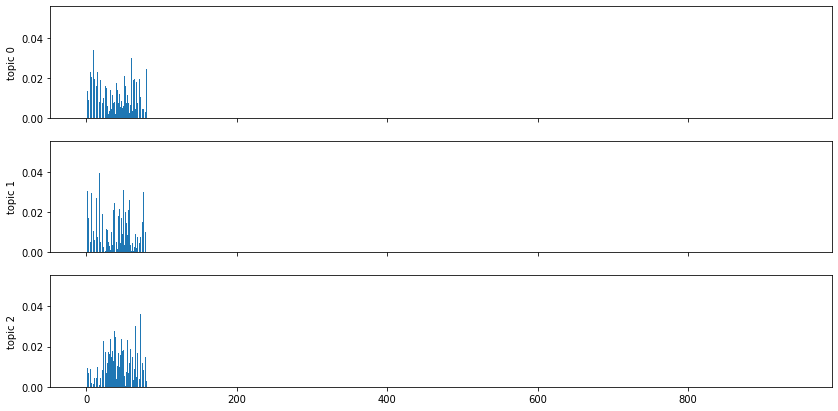

In [195]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(14,7))

x = range(len(dictionary))

for i, ax in enumerate(axes):
    ax.bar(range(len(term_topic_matrix[i])), term_topic_matrix[i], width=.8)
    ax.set_ylabel(f'topic {i}')
    #ax.set_yticks([])
    #ax.set_xticks([])

In [223]:
import re

first_n = 10

topic_sep = re.compile(r'0\.[0-9]{3}\*"|"')

model_topics = np.array([re.sub(topic_sep , '', model_topic).
    split(' + ') for topic_no , model_topic in lda_model.print_topics(num_words=first_n)])

model_topics

array([['call', 'carefully', 'critical', 'memorandum', 'decision',
        'initiative', 'european', 'assess', 'financing', 'basis'],
       ['important', 'impact', 'headline', 'financial', 'response',
        'unilateral', 'basis', 'primary_surplus', 'end', 'legal'],
       ['structural_reform', 'provide', 'proceed', 'yesterday',
        'facility', 'uh-', 'commission', 'successful_conclusion',
        'economic', 'fully']], dtype='<U21')

In [220]:
model_topics[0]

(0,
 ['call',
  'carefully',
  'critical',
  'memorandum',
  'decision',
  'initiative',
  'european',
  'assess',
  'financing',
  'basis'])

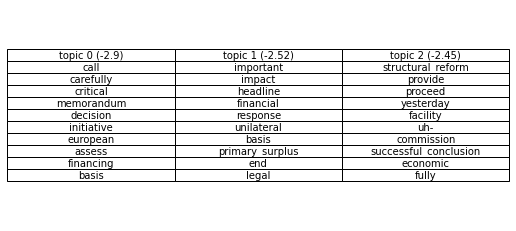

In [239]:
fig, ax = plt.subplots(figsize=(9,4))

ax.axis('off')
ax.table(model_topics.T,
         colLabels=[f'topic {i} ({c})' for i,c in enumerate(np.around(coherence_per_topic,2))],
         cellLoc='center',
         loc='center')

# this is probably better done by hand in latex

### delete me

In [20]:
first_n = 8

# pretty print
import re
topic_sep = re.compile(r"0\.[0 -9]{3}\*")

model_topics = [( topic_no , re.sub(topic_sep , '', model_topic).
    split(' + ')) for topic_no , model_topic in
        model.print_topics(num_topics=num_topics,
    num_words=first_n)]

descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:first_n]))
    descriptors.append(", ".join(m[:2]).replace('"', ''))

1 "referendum", "interest_rate", "environment", "wednesday", "implication", "cash", "9th", "update"
2 "timely", "palatable", "wording", "interject", "reject", "director", "external", "background"
3 "second_letter", "bill", "growth_friendly", "strategic", "saturday", "maximum_flexibility", "smart", "wrong"
4 "scheme", "elstat", "growth_friendly", "side", "installment", "concession", "adjourn", "valid"


In [21]:
from collections import defaultdict

topic_proportions = pd.DataFrame(np.zeros((len(topic_corpus), num_topics)))

for i,doc in enumerate(topic_corpus):
    for topic in doc:
        topic_proportions.iloc[i,topic[0]] = topic[1]
    
#pd.DataFrame(topic_proportions, index=dates)
topic_proportions.set_index(dates, inplace=True)

topic_proportions

,0,1,2,3
24/02,0.026300,0.025981,0.026327,0.921392
17/03,0.029733,0.029462,0.911100,0.029705
01/04,0.943643,0.018523,0.019066,0.018768
24/04,0.017846,0.017522,0.946694,0.017938
11/05,0.020623,0.020402,0.020804,0.938170
18/06,0.905684,0.031005,0.032083,0.031227
22/06,0.020834,0.020591,0.937764,0.020811
24/06,0.025688,0.025512,0.026127,0.922674
25/06,0.021207,0.021035,0.936385,0.021372
27/06,0.916973,0.027246,0.028090,0.027691


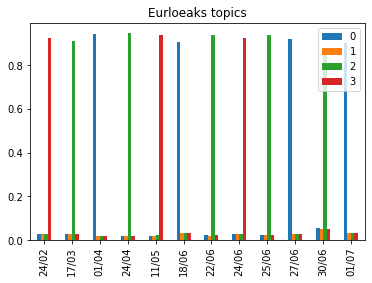

In [22]:
ax = topic_proportions.plot.bar()
_=ax.set_title('Eurloeaks topics')

## auxiliary

In [61]:
def search_term(term):
    for i,row in df.iterrows():
        if term in row.speech:
            date = pd.to_datetime(row.date).strftime('%d/%m')
            print(f'{row.speaker} ({date}):')
            print(row.speech)
            print()

In [65]:
#search_term('thoma')

## LDA author topic model with author=date

In [5]:
stopwords['time'] = [
    'monday',
    'tuesday',
    'wednesday',
    'thursday',
    'friday',
    'saturday',
    'sunday',
    'today',
    'yesterday',
    'tomorrow',
    'now',
    'before',
    'after',
    'day',
    'week',
    'month',
    #'year',
    'afternoon',
    'hour',
    'past',
    'present',
    'future',
    'january',
    'february',
    'march',
    'april',
    'may',
    'june',
    'july',
    'august',
    'september',
    'october',
    'november',
    'december',
]

In [117]:
context_stopwords = [
    'colleague',
    'comment',
    'maybe',
    'table',
    'start',
    'thank',
    'thing',
    'point',
    'need',
    'word',
    'question',
    'meeting',
    'discussion',
    'decision',
    'matter',
    'fact',
    'moment',
    'remark',
    'lot',
    'place',
    'way',
    'sense'
]

In [ ]:
def filter_token(token):
    return token.pos_ in {'ADJ', 'ADV', 'NOUN', 'PROPN', 'VERB'}\
        and not token.is_stop\
        and not token.text in stopwords['names']\
        and not token.lemma_ in stopwords['artifacts']\
        and not token.lemma_ in stopwords['time']\
        and not token.lemma_ in context_stopwords\
        and len(token.lemma_) > 1

# and not token.text in stopwords['weak_speaker_discriminants_0.1']\

In [163]:
t = time.time()

documents = [
    [token.lemma_ for sentence in nlp(doc).sents for token in sentence
            if filter_token(token)
    ]
    for doc in df.speech.values 
]

# apply collocations
documents = [
    apply_bigram_colloc(apply_trigram_colloc(' '.join(doc), trigram_colloc), bigram_colloc).split()
    for doc in documents]

print(f'Time taken: {round((time.time() - t) / 60, 2)} mins')

Time taken: 0.33 mins


In [164]:
print(f'There are a total of {np.sum([len(doc) for doc in documents])} tokens, and a total of {len(documents)} documents.')

There are a total of 13601 tokens, and a total of 1489 documents.


In [165]:
from gensim.models import LdaMulticore, TfidfModel
from gensim.corpora import Dictionary
import multiprocessing

In [166]:
dictionary = Dictionary(documents)

dictionary.filter_extremes(
    no_below=20,  # Keep tokens which are contained in at least no_below documents.
    no_above=.1 # Keep tokens which are contained in no more than no_above documents (fraction of total corpus size, not an absolute number).
)

In [167]:
print(dictionary)

Dictionary(123 unique tokens: ['commission', 'area', 'authority', 'basis', 'conclusion']...)


In [168]:
#for i in range(len(dictionary)):
#    print(dictionary.get(i))

In [169]:
ldacorpus = [dictionary.doc2bow(text) for text in documents]

tfidfmodel = TfidfModel(ldacorpus)

model_corpus = tfidfmodel[ldacorpus]

In [170]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(ldacorpus))

Number of unique tokens: 123
Number of documents: 1489


In [171]:
from collections import defaultdict

date2doc = defaultdict(list)

for i,row in df.iterrows():
    date = pd.to_datetime(row.date).strftime('%d/%m')
    date2doc[date].append(i)

In [172]:
from gensim.models import AuthorTopicModel
from gensim.test.utils import temporary_file

num_topics = 3
alpha = 'auto'
eta = 'auto'

with temporary_file("serialized") as s_path:
    
    author_model = AuthorTopicModel(
                    model_corpus,
                    author2doc=date2doc,
                    id2word=dictionary,
                    num_topics=num_topics,
                    serialized=True,
                    serialization_path=s_path,
                    passes=20,
                    alpha=alpha,
                    eta=eta
                    )

    author_model.update(model_corpus, date2doc)

In [173]:
topic_corpus = [author_model.get_author_topics(date) for date in date2doc.keys()]

In [174]:
# examine the learned topics
import pprint
pprint.pprint(author_model.print_topics())

[(0,
  '0.073*"line" + 0.064*"solution" + 0.060*"conclusion" + 0.054*"aide_memoire" '
  '+ 0.054*"case" + 0.034*"framework" + 0.034*"course" + 0.029*"direction" + '
  '0.029*"conference" + 0.029*"effort"'),
 (1,
  '0.115*"process" + 0.077*"interest_rate" + 0.065*"problem" + 0.052*"issue" + '
  '0.040*"letter" + 0.027*"statement" + 0.027*"couple" + 0.027*"answer" + '
  '0.027*"referendum" + 0.027*"situation"'),
 (2,
  '0.093*"people" + 0.078*"document" + 0.063*"progress" + 0.048*"time" + '
  '0.048*"greece" + 0.048*"ecb" + 0.033*"information" + 0.033*"stage" + '
  '0.032*"growth" + 0.032*"athen"')]


In [160]:
first_n = 10

# pretty print
import re
topic_sep = re.compile(r"0\.[0 -9]{3}\*")

model_topics = [( topic_no , re.sub(topic_sep , '', model_topic).
    split(' + ')) for topic_no , model_topic in
        author_model.print_topics(num_topics=num_topics,
    num_words=first_n)]

descriptors = []
for i, m in model_topics:
    print(i, ", ".join(m[:first_n]))
    descriptors.append(", ".join(m[:2]).replace('"', ''))

0 "process", "meeting", "people", "interest_rate", "thing", "ecb", "discussion", "aide_memoire", "fact", "greece"
1 "colleague", "comment", "line", "document", "progress", "decision", "word", "referendum", "issue", "framework"
2 "thank", "problem", "solution", "course", "statement", "table", "stage", "parliament", "time", "effort"


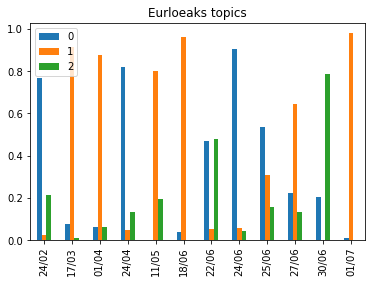

In [161]:
from collections import defaultdict

dates = pd.Series(df.date.unique()).apply(lambda s: pd.to_datetime(s).strftime('%d/%m')).values

topic_corpus = [author_model.get_author_topics(date) for date in date2doc.keys()]

topic_proportions = pd.DataFrame(np.zeros((len(topic_corpus), num_topics)))

for i,doc in enumerate(topic_corpus):
    for topic in doc:
        topic_proportions.iloc[i,topic[0]] = topic[1]
    
#pd.DataFrame(topic_proportions, index=dates)
topic_proportions.set_index(dates, inplace=True)

ax = topic_proportions.plot.bar()
_=ax.set_title('Eurloeaks topics')

# Communiques

## load data

In [65]:
# read data
df = pd.read_csv('../data/communiques/cleaned.csv')
    
# collocations
def apply_trigram_colloc(s, set_colloc):
    res = s.lower()
    for b1,b2,b3 in set_colloc:
        res = res.replace(f'{b1} {b2} {b3}', f'{b1}_{b2}_{b3}')
    return res

def apply_bigram_colloc(s, set_colloc):
    res = s.lower()
    for b1,b2 in set_colloc:
        res = res.replace(f'{b1} {b2}', f'{b1}_{b2}')
    return res

with open('../data/collocations/trigrams.json', 'r') as f:
    trigram_colloc = json.load(f)

with open('../data/collocations/bigrams.json', 'r') as f:
    bigram_colloc = json.load(f)

## LDA topic model

### preprocessing

In [66]:
def filter_token(token):
    return token.pos_ in {'ADJ', 'ADV', 'NOUN', 'PROPN', 'VERB'}\
        and not token.is_stop\
        and len(token.lemma_) > 1

t = time.time()

documents = [
    [token.lemma_ for sentence in nlp(doc).sents for token in sentence
            if filter_token(token)
    ]
    for doc in df.story.values 
]

# apply collocations
documents = [
    apply_bigram_colloc(apply_trigram_colloc(' '.join(doc), trigram_colloc), bigram_colloc).split()
    for doc in documents]

print(f'Time taken: {round((time.time() - t) / 60, 2)} mins.')

print(f'There are a total of {np.sum([len(doc) for doc in documents])} tokens, and a total of {len(documents)} documents.')

Time taken: 0.01 mins.
There are a total of 3640 tokens, and a total of 18 documents.


### dictionary: filter extremes

In [67]:
from gensim.models import LdaMulticore, TfidfModel
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
import multiprocessing

In [68]:
dictionary = Dictionary(documents)

no_below = 1 # Keep only tokens which are contained in at least no_below documents.
no_above = .1 # Keep tokens which are contained in no more than no_above documents (fraction of total corpus size, not an absolute number).

In [69]:
# see what will be removed
no_below_removed = [dictionary.get(token_id) for token_id, freq in dictionary.cfs.items() if freq < no_below]
no_above_removed = [dictionary.get(token_id) for token_id, freq in dictionary.dfs.items() if freq > no_above * len(documents)]

print(f'no_below will remove {len(no_below_removed)} tokens.')
print(f'no_above will remove {len(no_above_removed)} tokens.')

no_below will remove 0 tokens.
no_above will remove 481 tokens.


In [70]:
dictionary.filter_extremes(
    no_below=no_below,
    no_above=no_above
)

In [71]:
corpus = [dictionary.doc2bow(text) for text in documents]

tfidfmodel = TfidfModel(corpus)

tfidf_corpus = tfidfmodel[corpus]

- Q: should I use term-document frequency (BoW) or TF-IDF as input to LDA? A: use it as a hyperparameter in the grid search.

In [72]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 464
Number of documents: 18


In [73]:
def filter_extremes(documents, no_below, no_above):
    
    dictionary = Dictionary(documents)
    dictionary.filter_extremes(no_below=no_below, no_above=no_above)
    
    corpus = [dictionary.doc2bow(text) for text in documents]

    tfidfmodel = TfidfModel(corpus)

    tfidf_corpus = tfidfmodel[corpus]
    
    return dictionary, tfidf_corpus

### basic model

In [77]:
t = time.time()

lda_model = LdaMulticore(corpus=tfidf_corpus,
                         id2word=dictionary,
                         num_topics=2, 
                         random_state=100,
                         iterations=400,
                         passes=20
                        )

print(f'Time taken: {round((time.time() - t) / 60, 2)} mins')

Time taken: 0.02 mins


In [78]:
from pprint import pprint

pprint(lda_model.print_topics())

[(0,
  '0.004*"question" + 0.004*"difficult" + 0.004*"result" + 0.004*"initiative" '
  '+ 0.004*"wait" + 0.004*"inevitable" + 0.004*"ask" + 0.004*"certainly" + '
  '0.004*"consist" + 0.004*"preservation"'),
 (1,
  '0.005*"pm" + 0.004*"concerned" + 0.003*"develop" + 0.003*"speedy" + '
  '0.003*"broaden" + 0.003*"coordination" + 0.003*"trust" + 0.003*"undertake" '
  '+ 0.003*"credible" + 0.003*"streamlining"')]


In [79]:
from gensim.models import CoherenceModel

coherence_model_lda = CoherenceModel(model=lda_model,
                                     corpus=corpus,
                                     coherence='u_mass')

coherence_lda = coherence_model_lda.get_coherence()
print(f'\nCoherence Score: {coherence_lda}')


Coherence Score: -20.31337526238126


### grid search: k, alpha, beta

In [80]:
import multiprocessing
n_cores = multiprocessing.cpu_count() - 1

In [81]:
# supporting function
def compute_coherence_values(corpus, dictionary, num_topics, alpha, beta):
    
    lda_model = LdaMulticore(corpus=corpus,
                             id2word=dictionary,
                             num_topics=num_topics, 
                             random_state=100,
                             iterations=400,
                             passes=20,
                             alpha=alpha,
                             eta=beta,
                             workers=n_cores)
    
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         corpus=corpus, 
                                         coherence='u_mass')
    
    return coherence_model_lda.get_coherence()

TF-IDF yields better coherence score consistently, so just use that.

In [82]:
# filter extremes
no_belows = [0]
no_aboves = [.1, .5, 1]

# k = number of topics hyperparameter
topics_range = range(1,7)

# alpha hyperparameter
alpha = [.01, .3, .6, 1]
alpha.append('symmetric')
alpha.append('asymmetric')

# beta hyperparameter
beta = [.01, .3, .6, 1]
beta.append('symmetric')


model_results = {'no_below': [],
                 'no_above': [],
                 'corpus': [],
                 'num_topics': [],
                 'alpha': [],
                 'beta': [],
                 'coherence': []
                }

number_of_runs = len(no_belows) * len(no_aboves) * len(topics_range) * len(alpha) * len(beta)
print(f'You are about to execute {number_of_runs} runs. This could take up to {np.round(number_of_runs*0.3,2)} minutes.')

You are about to execute 540 runs. This could take up to 162.0 minutes.


In [83]:
import tqdm

with tqdm.tqdm(total=number_of_runs) as pbar:
    
    # iterate through filter extremes
    for no_below in no_belows:
        for no_above in no_aboves:
            
            dictionary, tfidf_corpus = filter_extremes(documents, no_below, no_above)
    

            # iterate through number of topics
            for k in topics_range:
                # iterate through alpha values
                for a in alpha:
                    # iterare through beta values
                    for b in beta:
                        # get the coherence score for the given parameters
                        cv = compute_coherence_values(corpus=tfidf_corpus,
                                                      dictionary=dictionary, 
                                                      num_topics=k,
                                                      alpha=a,
                                                      beta=b)
                        # save the model results
                        model_results['no_below'].append(no_below)
                        model_results['no_above'].append(no_above)
                        model_results['corpus'].append('tfidf')
                        model_results['num_topics'].append(k)
                        model_results['alpha'].append(a)
                        model_results['beta'].append(b)
                        model_results['coherence'].append(cv)

                        # update process bar
                        pbar.update(1)
                
pd.DataFrame(model_results).to_csv('../data/communiques/lda_tuning_results.csv', index=False)

  2%|▏         | 10/540 [00:11<09:59,  1.13s/it]


KeyboardInterrupt: 

### best model

In [102]:
# find best combination of hyperparams
results = pd.read_csv('../data/communiques/lda_tuning_results.csv')
best = results.iloc[np.argmin(results['coherence'])]
best

no_below             5
no_above          0.05
corpus          TF-IDF
num_topics           3
alpha             0.01
beta              0.01
coherence    -6.469997
Name: 5, dtype: object

In [197]:
# train basic LDA model with those hyperparameters

dictionary, corpora = filter_extremes(documents, best['no_below'], best['no_above'])

lda_model = LdaMulticore(corpus=corpus if best['corpus'] == corpus_title[0] else tfidf_corpus,
                         id2word=dictionary,
                         num_topics=best['num_topics'],
                         alpha=best['alpha'],
                         eta=best['beta'],
                         random_state=100,
                         iterations=400,
                         passes=20
                        )


# get coherence per topic

coherence_model_lda = CoherenceModel(model=lda_model,
                                     corpus=corpus, 
                                     coherence='u_mass')

coherence_per_topic = coherence_model_lda.get_coherence_per_topic()

In [198]:
pprint(lda_model.print_topics(num_words=10))

[(0,
  '0.036*"call" + 0.034*"carefully" + 0.030*"critical" + 0.030*"memorandum" + '
  '0.025*"decision" + 0.025*"initiative" + 0.023*"european" + 0.023*"assess" + '
  '0.021*"financing" + 0.021*"basis"'),
 (1,
  '0.053*"important" + 0.040*"impact" + 0.034*"headline" + 0.031*"financial" + '
  '0.030*"response" + 0.030*"unilateral" + 0.030*"basis" + '
  '0.029*"primary_surplus" + 0.027*"end" + 0.026*"legal"'),
 (2,
  '0.036*"structural_reform" + 0.033*"provide" + 0.030*"proceed" + '
  '0.027*"yesterday" + 0.026*"facility" + 0.025*"uh-" + 0.024*"commission" + '
  '0.024*"successful_conclusion" + 0.024*"economic" + 0.023*"fully"')]


In [199]:
pprint(coherence_per_topic)

[-2.897759885374639, -2.5239345701526106, -2.447363189828585]
